In [1]:
# importing libraries needed

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

import pyspark.sql.functions as F
from pyspark.sql.functions import when, min, max, col, round, lower, trim, countDistinct, count, sum, month, hour
from pyspark.sql import Window

from pyspark.sql.functions import sum as spark_sum, col, when

## Starting PySpark session

In [2]:
# sets logging level for py4j (used by pyspark to communicate with JVM, Java Virtual Machine)

import logging
logging.getLogger("py4j").setLevel(logging.INFO)

In [4]:
from pyspark.sql import SparkSession

spark = SparkSession.builder \
        .appName("EDA") \
        .config("spark.ui.showConsoleProgress", "false") \
        .config("spark.local.dir", "C:/temp/spark") \
        .getOrCreate()

spark

In [5]:
# Load cleaned datasets and functions created

# Add src to the Python path if needed
import sys
sys.path.append("../raw_functions")

from raw_functions.delivery_time import time_taken_to_deliver, flag_delivery_speed_relative
from raw_functions.distance import add_order_delivery_distance
from raw_functions.installment_flagging import add_high_installment_flag
from raw_functions.product_category import get_category_in_english, group_categories_by_sales_with_ohe
from raw_functions.repeat_buyers import finding_repeat_buyers
from raw_functions.final_dataset import build_final_dataset

df_orders           = spark.read.option('header', 'true').option('inferSchema', 'true').csv("raw_functions/cleaned_data/cleaned_orders.csv", header=True)
df_customers        = spark.read.option('header', 'true').option('inferSchema', 'true').csv("raw_functions/cleaned_data/cleaned_customers.csv", header=True)
df_order_items      = spark.read.option('header', 'true').option('inferSchema', 'true').csv("raw_functions/cleaned_data/cleaned_order_items.csv", header=True)
df_products         = spark.read.option('header', 'true').option('inferSchema', 'true').csv("raw_functions/cleaned_data/cleaned_products.csv", header=True)
df_order_payments   = spark.read.option('header', 'true').option('inferSchema', 'true').csv("raw_functions/cleaned_data/cleaned_order_payments.csv", header=True)
df_sellers          = spark.read.option('header', 'true').option('inferSchema', 'true').csv("raw_functions/cleaned_data/cleaned_seller.csv", header=True)
df_order_reviews        = spark.read.option('header', 'true').option('inferSchema', 'true').csv("raw_functions/cleaned_data/cleaned_reviews.csv", header=True)
df_geolocation      = spark.read.option('header', 'true').option('inferSchema', 'true').csv("raw_functions/cleaned_data/cleaned_geolocation.csv", header=True)
df_product_category = spark.read.option('header', 'true').option('inferSchema', 'true').csv("raw_functions/cleaned_data/product_category_name_translation.csv", header=True)

print("All done!")

All done!


## Introduction to EDA

Objectives for this EDA:

1. Understand and doing basic cleaning on the datasets given
- Find missing values, duplicates or data that have inconsistent formats
- Identify and handle outliers
- Checking for invalid timestamps (e.g. delivery occurs before purchase date)

2. Distribution of data and relationship
- Most commmon product categories, payment methods, purchase hour

3. Customer Behaviour Analysis
- How many repeat buyers exist?
- Average time between orders for repeat buyers
- Preference of repeat buyers (What are they repurchasing)

4. Payment analysis
- Does customers who make paymetns with vouchers behave diffferntly?
- Is there a relationship between high installments (high installment value/high amount of installments made) and low repurchases?

5. Delivery pattern
- How long does delivery take?
- Will long delivery duration cause bad reviews or lower chances of repeat orders?
- Distance between customer and seller

6. Review score
- Are review scores linked to repeat purchases?

7. Product category
- Which product categories are the most popular?
- Group categories which are not popular under 'others'
- Do one-hot encoding on product categories

Final EDA Goal:

To prepare, clean, insightful dataset with features that will be helpful in helping the model to find repeat buyers.

### 1. Understanding and doing basic cleaning on datasets

In [ ]:
# christel's code will be in/under this markdown cell

# Find missing values, duplicates or data that have inconsistent formats
# Identify and handle outliers
# Checking for invalid timestamps (e.g. delivery occurs before purchase date)

### 2. Distribution of data and relationship

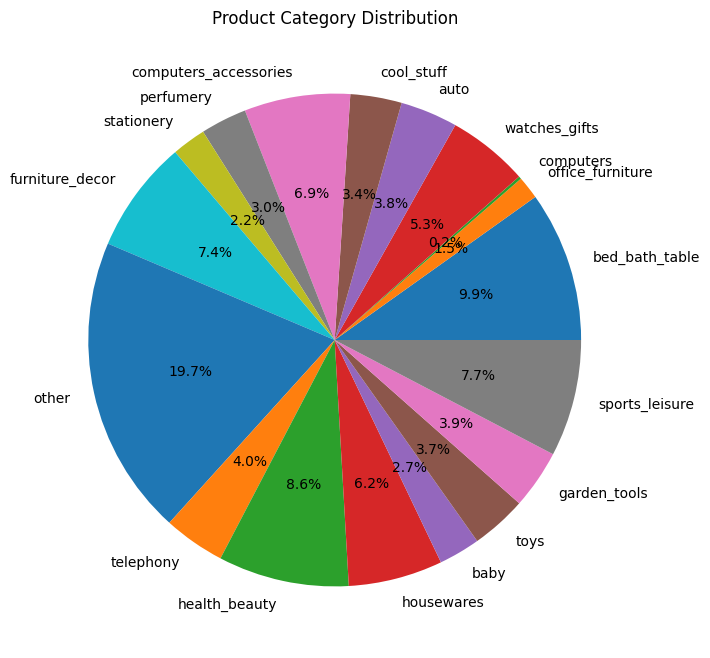

In [36]:
# most common roducts
df_category_price = get_category_in_english(df_order_items, df_products, df_product_category)
df_ohe = group_categories_by_sales_with_ohe(df_category_price, category_col="product_category_name_english", value_col="price", threshold=0.8)
df_grouped_counts_pd = df_ohe.groupBy("category_grouped").count().toPandas()

# Now, plot the Pandas DataFrame which has the 'count' column
df_grouped_counts_pd.set_index("category_grouped").plot.pie(y="count", autopct='%1.1f%%', figsize=(25, 8)).legend().remove()
plt.ylabel("")
plt.title("Product Category Distribution")
plt.show()

### 3. Customer Behaviour Analysis

In [ ]:
# How many repeat buyers exist?
# Average time between orders for repeat buyers
# Preference of repeat buyers (What are they repurchasing)

### 4. Payment analysis

### 3. Customer Behaviour Analysis

In [ ]:
# Does customers who make paymetns with vouchers behave diffferntly?
# Is there a relationship between high installments (high installment value/high amount of installments made) and low repurchases?

root
 |-- order_id: string (nullable = true)
 |-- order_purchase_timestamp: timestamp (nullable = true)
 |-- order_delivered_customer_date: timestamp (nullable = true)
 |-- time_of_purchase: integer (nullable = true)
 |-- month_of_purchase: integer (nullable = true)
 |-- delivered_in_days: double (nullable = true)



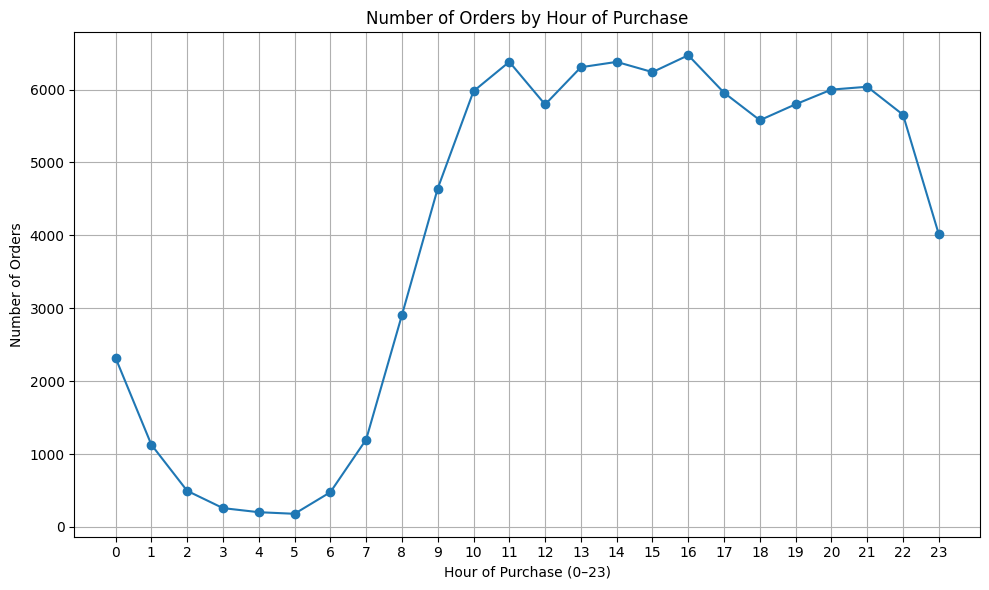

In [38]:
df_time = time_taken_to_deliver(df_orders)

df_time.printSchema()

from pyspark.sql.functions import to_timestamp, hour

df_time_clean = df_time \
    .withColumn("order_purchase_timestamp", to_timestamp("order_purchase_timestamp")) \
    .withColumn("order_delivered_customer_date", to_timestamp("order_delivered_customer_date")) \
    .withColumn("time_of_purchase", hour("order_purchase_timestamp")) \
    .select("time_of_purchase") \
    .filter("time_of_purchase IS NOT NULL")

delivery_pd = df_time_clean.toPandas()

orders_by_hour = delivery_pd.groupby('time_of_purchase').size().reset_index(name='num_orders')

plt.figure(figsize=(10,6))
plt.plot(orders_by_hour['time_of_purchase'], orders_by_hour['num_orders'], marker='o', linestyle='-')
plt.title("Number of Orders by Hour of Purchase")
plt.xlabel("Hour of Purchase (0–23)")
plt.ylabel("Number of Orders")
plt.xticks(range(0, 24))  # make sure all 24 hours show
plt.grid(True)
plt.tight_layout()


Purchases by customers peak from 12pm till 5pm

### 5. Delivery pattern

In [ ]:
# How long does delivery take?
# Will long delivery duration cause bad reviews or lower chances of repeat orders?
# Distance between customer and seller

In [9]:
final_df = build_final_dataset(
    df_order_items, df_products, df_product_category, df_orders,
    df_customers, df_sellers, df_order_payments, df_geolocation, df_order_reviews
)

In [10]:
final_df.show()

+--------------------+--------------------+--------------------+-----------------+----------------+-----------------+-------------------+-----------------------+-----------------+---------------------+------------+---------------+----------+--------------------+--------------------+--------------------+------------+
|            order_id|  customer_unique_id|         customer_id|delivered_in_days|time_of_purchase|month_of_purchase|delivery_speed_flag|delivery_distance_in_km|installment_value|high_installment_flag|used_voucher|is_repeat_buyer|num_orders|total_purchase_value|category_grouped_ohe|          product_id|review_score|
+--------------------+--------------------+--------------------+-----------------+----------------+-----------------+-------------------+-----------------------+-----------------+---------------------+------------+---------------+----------+--------------------+--------------------+--------------------+------------+
|00042b26cf59d7ce6...|64b576fb70d441e8f...|58d

### 6. Review score

In [ ]:
# Are review scores linked to repeat purchases?

### 7. Product category

In [ ]:
# Which product categories are the most popular?
# Group categories which are not popular under 'others'
# Do one-hot encoding on product categories